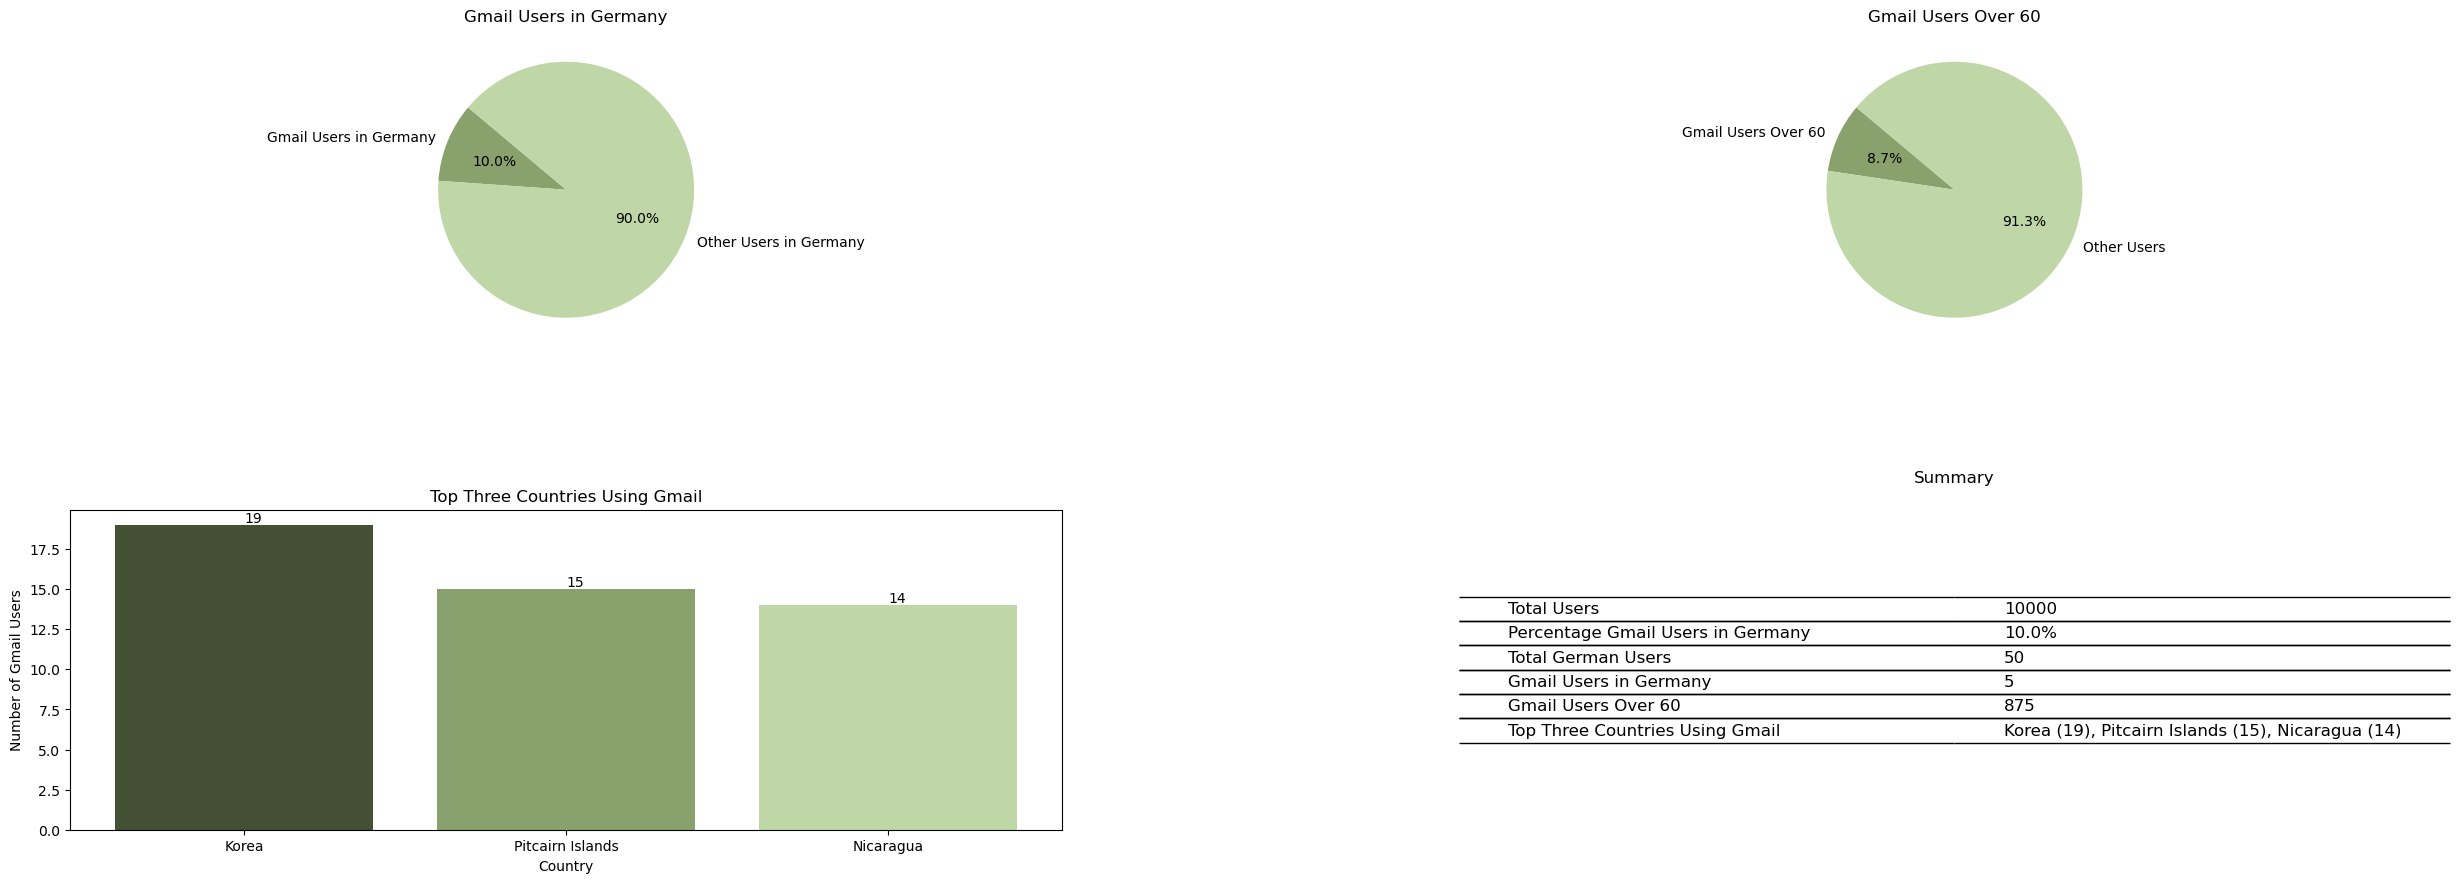

In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to SQLite database
db_path = r'C:\Users\Aqsa khan\taxfixUsers.db'
conn = sqlite3.connect(db_path)

# Execute the SQL query
query = """
WITH TotalUsers AS (
    SELECT COUNT(*) AS total_users
    FROM users
),
TotalUsersGermany AS (
    SELECT COUNT(*) AS total_german_users
    FROM users
    WHERE country = 'Germany'
),
GmailUsersGermany AS (
    SELECT COUNT(*) AS gmail_users_germany
    FROM users
    WHERE country = 'Germany' AND email LIKE '%@gmail.com'
),
TopCountries AS (
    SELECT country, COUNT(*) AS gmail_user_count
    FROM users
    WHERE email LIKE '%@gmail.com'
    GROUP BY country
    ORDER BY gmail_user_count DESC
    LIMIT 3
),
GmailUsersOver60 AS (
    SELECT COUNT(*) AS gmail_users_over_60 FROM users WHERE CAST(SUBSTR(birthday, 2, INSTR(birthday, '-') - 2) AS INTEGER) >= 60 AND email LIKE '%@gmail.com'
)
SELECT 
    (SELECT total_users FROM TotalUsers) AS total_users, 
    ((SELECT gmail_users_germany * 100.0 FROM GmailUsersGermany )/ (SELECT total_german_users FROM TotalUsersGermany)) AS percentage_gmail_users_germany,
    (SELECT total_german_users FROM TotalUsersGermany) AS total_german_users,
    (SELECT gmail_users_germany FROM GmailUsersGermany) AS gmail_users_germany,
    (SELECT gmail_users_over_60 FROM GmailUsersOver60) AS gmail_users_over_60,
    GROUP_CONCAT(country || ' (' || gmail_user_count || ')', ', ') AS top_three_countries_gmail
FROM TopCountries;
"""

# Execute the query and fetch data
result = pd.read_sql(query, conn)
conn.close()

# Extract results
total_users = result['total_users'].iloc[0]
percentage_gmail_users_germany = result['percentage_gmail_users_germany'].iloc[0]
total_german_users = result['total_german_users'].iloc[0]
gmail_users_germany = result['gmail_users_germany'].iloc[0]
users_over_60_using_gmail = result['gmail_users_over_60'].iloc[0]
top_three_countries_gmail = result['top_three_countries_gmail'].iloc[0]

# Reshape the data into a vertical table format
data = {
    'Parameter': [
        'Total Users',
        'Percentage Gmail Users in Germany',
        'Total German Users',
        'Gmail Users in Germany',
        'Gmail Users Over 60',
        'Top Three Countries Using Gmail'
    ],
    'Value': [
        total_users,
        f'{percentage_gmail_users_germany:.1f}%',
        total_german_users,
        gmail_users_germany,
        users_over_60_using_gmail,
        top_three_countries_gmail
    ]
}
vertical_table = pd.DataFrame(data)

# Data for plotting
labels_germany = ['Gmail Users in Germany', 'Other Users in Germany']
sizes_germany = [percentage_gmail_users_germany, 100 - percentage_gmail_users_germany]
colors_pie_germany = ['#89a26d', '#bfd6a6']
explode_pie_germany = (0, 0)  # explode 1st slice

labels_over_60_users = ['Gmail Users Over 60', 'Other Users']
sizes_over60 = [users_over_60_using_gmail, total_users - users_over_60_using_gmail]
colors_pie_over60 = ['#89a26d', '#bfd6a6']
explode_pie_over60 = (0, 0) 

# Data for top three countries
countries = [item.split(' (')[0] for item in top_three_countries_gmail.split(', ')]
gmail_counts = [int(item.split(' (')[1].rstrip(')')) for item in top_three_countries_gmail.split(', ')]

# Create the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Pie chart for percentage of Gmail users in Germany
axs[0, 0].pie(sizes_germany, explode=explode_pie_germany, labels=labels_germany, colors=colors_pie_germany, autopct='%1.1f%%', shadow=False, startangle=140)
axs[0, 0].set_title('Gmail Users in Germany')

# Pie chart for users over 60 using Gmail
axs[0, 1].pie(sizes_over60, explode=explode_pie_over60, labels=labels_over_60_users, colors=colors_pie_over60, autopct='%1.1f%%', shadow=False, startangle=140)
axs[0, 1].set_title('Gmail Users Over 60')

# Bar chart for top three countries using Gmail
bars = axs[1, 0].bar(countries, gmail_counts, color=['#435034', '#89a26d', '#bfd6a6'])
axs[1, 0].set_xlabel('Country')
axs[1, 0].set_ylabel('Number of Gmail Users')
axs[1, 0].set_title('Top Three Countries Using Gmail')

# Adding text labels
for bar in bars:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Vertical table of results
axs[1, 1].axis('off')  # Hide axis
table = axs[1, 1].table(cellText=vertical_table.values, colLabels=None, cellLoc='left', loc='center', edges='horizontal')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.6)  # Adjust the table size for better fit

# Add title for the table
axs[1, 1].set_title('Summary', pad=20)

# Adjust layout to ensure everything fits
plt.subplots_adjust(left=0.1, right=1.8, top=0.9, bottom=0.1, wspace=0.4, hspace=0.5)

plt.show()
